### Erstellen eines Prognosemodells für den Energieverbrauch


Dieses Notebook zeigt
- wie man mithilfe eines Entscheidungsbaums ein Vorhersagemodell für den Energieverbrauch erstellen kann
- wie man die Modell-Performance bewerten kann
- wie man die Modell-Performance optimieren kann (Hyperparameteroptimierung)

In [1]:
### Bibliotheken einbinden

## Datenanalyse
import pandas as pd
import numpy as np

## Plotten
import matplotlib.pyplot as plt
# zeige Plots in Zellen des Notebooks an
%matplotlib inline 
import seaborn as sns
# setze seaborn style defaults und Default-Wert für Plotgröße
sns.set(rc={'figure.figsize':(20, 10)}) 

## Maschinelles Lernen
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import export_text
from sklearn import tree
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Google Drive mounten
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

## Aufgabe 1
Lesen Sie den Datensatz Energieverbrauch.csv ein und geben Sie sich die ersten Spalten aus.

In [3]:
#data = pd.read_csv('/content/drive/My Drive/Energieverbrauch.csv')
data = pd.read_csv("Energieverbrauch.csv")
data.iloc[:,0]

0       2012-01-01
1       2012-01-02
2       2012-01-03
3       2012-01-04
4       2012-01-05
           ...    
2182    2017-12-27
2183    2017-12-28
2184    2017-12-29
2185    2017-12-30
2186    2017-12-31
Name: Date, Length: 2187, dtype: object

## Aufgabe 2
- Sie wollen ein Vorhersagemodell für den Energiebedarf erstellen.
- Indizieren Sie dazu zunächst das Dataframe mit dem Zeitstempel. 
- Vergessen Sie dabei nicht, das Datenformat der Spalte Date falls nötig zu ändern

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Consumption
Date,
2012-01-01,948.128
2012-01-02,1269.581
2012-01-03,1334.745
2012-01-04,1347.136
2012-01-05,1376.658


## Aufgabe 3
- Für das Vorhersagemodell wollen Sie folgende Merkmale heranziehen: 
    Jahr, Monat, Wochentag (0,1,2,3...,6 für Mo-So)
- Solche zeitlichen Merkmale können Sie ganz leicht mithilfe des Zeitstempel-Index generieren. 
- Für den Wochentag wurde das unten beispielhaft schon durchgeführt. 
- Fügen Sie auf ähnliche Weise zwei weitere Spalten mit den Merkmalen Jahr und Monat ein. Hinweis: Verwenden Sie dazu die Attribute year und month des index.
- Geben Sie sich Teile des Dataframes aus und inspizieren Sie die neu hinzugefügten Merkmale.

In [29]:
data['Weekday'] = data.index.weekday
data["Year"] = data.index.year
data["Month"] = data.index.month

data.head()
# Das hier noch anpassen
#data['Year'] = data.index. ...
#data['Month'] = data.index. ...

,Consumption,Weekday,Month,Year,Weekend
Date,,,,,
2012-01-01,948.128,6,1,2012,1
2012-01-02,1269.581,0,1,2012,0
2012-01-03,1334.745,1,1,2012,0
2012-01-04,1347.136,2,1,2012,0
2012-01-05,1376.658,3,1,2012,0


## Aufgabe 4
- Weiterhin wollen Sie das Merkmal Wochenende 0/1 generieren. 
- Wie das funktioniert, sieht man in der unteren Zelle.
- Gehen Sie den Code durch und versuchen Sie zu verstehen, was passiert

In [30]:
data['Weekend'] = [0 if x < 5 else 1 for x in data.index.weekday]
data.head()

###Beschreibung des Codes:
#Füge neue Spalte 'Weekend' in DF ein
#Die neue Spalte 'Weekend' wird so erzeugt:
#für alle Zeile aus 'weekday':
# 1) Wenn der Wert < 5 entspricht "Montag(0), Dienstag(1), Mittwoch(2), Donnerstag(3), Freitag(4)" setze neuen Wert mit "0" bei 'Weekend' also dieser Tag ist nicht am Wochenende
# 2) Wenn der Wert >= 5 entspricht "Samstag(5), Sonntag(6)" setze neuen Wert mit "1" bei 'Weekend' also dieser Tag ist am Wochenende

,Consumption,Weekday,Month,Year,Weekend
Date,,,,,
2012-01-01,948.128,6,1,2012,1
2012-01-02,1269.581,0,1,2012,0
2012-01-03,1334.745,1,1,2012,0
2012-01-04,1347.136,2,1,2012,0
2012-01-05,1376.658,3,1,2012,0


## Aufgabe 5
- Unten kommt eine Zelle mit einer Hilfsfunktion. Sie müssen die Zelle einfach nur ausführen. Die Funktion an sich müssen Sie nicht verändern. 
- Versuchen Sie zu verstehen, was passiert. Was macht die Hilfsfunktion?




Antwort:
1) df.sample(frac=1): return zufällig "1.0" * len(df) items also alle sample aus df
2) np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))]): aus df.sample(frac=1) wird gesplit und zwar in 3 Teilen
    - erste Teil: von 0 bis int(.6*len(df)) für df_train entspricht 60% der Daten
    - zweite Teil: von int(.6*len(df)) bis int(.8*len(df)) für df_validate entspricht 0.8-0.6 = 0.2 = 20% der Daten
    - dritte Teil: von int(.8*len(df)) bis 1.0 * len(df) für df_test entspricht 1.0-0.8 = 0.2 = 20% der Daten
3) Setze y_train, y_validate, y_test = Spalte 'Consumption' aus df_train, df_validate, df_test
4) X_train, X-validate, X_test sind wie aus df_* aber ohne die zwei Spalte 'Consumption' und 'Year'
5) return X_train, y_train, X_validate, y_validate, X_test, y_test

In [31]:
# Hilfsfunktion
def generate_sets(df): 
    
    # Spalte df auf in Trainings-, Validierungs- und Testmenge in den Anteilen 60%, 20%, 20%
    df_train, df_validate, df_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])        
        
    # Auswahl der Label durch Auswahl der entsprechenden Spalten                 
    y_train = df_train['Consumption']
    y_validate = df_validate['Consumption']
    y_test = df_test['Consumption']
        
    # Merkmale nicht in des Modell einbeziehen und somit die jeweiligen Spalten aus dem Datensatz entfernen
    X_train = df_train.drop(['Consumption','Year'], axis=1)
    X_validate = df_validate.drop(['Consumption','Year'], axis=1)
    X_test = df_test.drop(['Consumption','Year'], axis=1)                                                                          
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test
    

## Aufgabe 6
- Oben in der Hilfsfunktion wird das Merkmal 'Year' aus den Datensätzen entfernt und nicht in das Modell einbezogen. Warum macht das Sinn?
- Weiterhin wird aus X_train/validate/test die Spalte "Consumption" gelöscht. Wieso macht das Sinn?
- Wozu braucht man Trainings-, Validierungs- und Testmenge?

Antwort:
1) Das Merkmal 'Year' aus den Datensätzen wird entfernt. Das ist sinnvoll weil:
-Wie vorherige Praktika möchten wir den Energieverbrauch im Monat (und/oder Tage, Wochenende, nicht Wochenende) vorhersagen.
2) Die Spalte "Consumption" wird aus X_train/validate/test gelöscht. Das macht Sinn weil wir haben die Werte in y_train/validate/test schon abgespeichert und wahrscheinlich brauchen wir nicht "Consumption"-Werte doppel zu haben.
3) Trainings-, Validierungs- und Testmenge?
-Trainningsmenge braucht man um die Entscheindungsbaeume abhängig von Hyperparameter aufzubauen
-Validierungsmenge braucht man um die beste Hyperparameter bzw. den besten Entscheidungsbaum zu finden
-Testmenge braucht man zum Schluss die Performance auf dem besten Entscheidungsbaum zu testen bzw. Overfitting, Underfitting festzustellen

In [32]:
# Datensatz aufteilen in Trainings-, Validierungs- und Testmenge mit der Hilfsfunktion:
X_train, y_train, X_val, y_val, X_test, y_test = generate_sets(data)

## Aufgabe 7
- Es folgt eine Hilfsfunktion zum Trainieren eines Entscheidungsbaum und der graphischen Ausgabe des trainierten Baumes.
- Auch an dieser Funktion müssen Sie nichts ändern.
- Vielleicht verstehen Sie Teile der Funktion?
- Schauen Sie sich an, wie man Funktionen zum leichteren Verständnis mittels ''' ''' kommentieren kann

In [33]:
# Hilfsfunktion 2
def train_decision_tree(X_train, y_train, min_samples_split = 2, min_samples_leaf = 1, output=False):
    '''
    Hilfsfunktion zum Trainieren eines Entscheidungsbaumes auf einer Trainingsmenge.
    
    Inputs: 
    X_train (df): Dataframe mit den Merkmalsvektoren der Trainingsmenge
    y_train (df): Dataframe mit den Labeln der Trainingsmenge
    min_samples_split (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Split,
                                        wenn int, Mindestanzahl Samples in jedem Split
    min_samples_split (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Blatt des Entscheidungsbaumes,
                                        wenn int, Mindestanzahl Samples in jedem Blatt
    output (bool): ob eine Ausgabe erzeugt werden soll (Die Ausgabe enthält die Regeln des Entscheidungsbaumes und eine graphische 
                   Darstellung des Entscheidungsbaumes)
                   
    Outputs:
    dtr: ein auf der Trainingsmenge trainierter Entscheidungsbaum, der nachfolgend zur Prognose verwendet werden kann          
    '''
    
    # Spaltennamen (=Namen der Merkmale) für später speichern
    feature_names = list(X_train.columns)
    
    # Dataframes in numpy arrays konvertieren, da der Entscheidungsbaum das als Input benötigt
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    #Entscheidungsbaum mit bestimmten Hyperparametern (min_samples_splkit und min_samples_leaf intialisieren)
    dtr = DecisionTreeRegressor(random_state = 0, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    # Entscheidungsbaum trainieren
    dtr.fit(X_train, y_train)
    
    # Optionale Ausgabe generieren
    if output:
        
        rules = export_text(dtr, feature_names = feature_names)
        print(rules)
        print('Folgende Merkmale waren verfügbar:', feature_names)
        
        with plt.style.context('classic'):
            plt.figure(figsize=(20,10))
            tree.plot_tree(dtr, filled=True, impurity=True, rounded=True, feature_names=feature_names)
    
    return dtr

### Aufgabe 8:
- Als nächstes wollen wir einen Entscheidungsbaum auf dem Trainingsdatensatz trainieren. 
- Dazu wird die Hilfsfunktion train_decision_tree herangezogen. 
- Diese enthält die Parameter min_samples_split und min_samples_leaf
- Was bedeuten diese Parameter? Versuchen Sie dies mithilfe der Dokumentation zu klären:  
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- Was passiert wenn Sie diese Parameter verändern?
- Führen Sie die Funktion in der untenstehenden Zelle mehrfach aus und variieren Sie dabei z.B. min_samples_split zwischen 2 und 2000. Probieren Sie mindestens 10 verschiedene Werte in diesem Bereich aus und betrachten den entstehenden Entscheidungsbaum

|--- Weekend <= 0.50
|   |--- Month <= 3.50
|   |   |--- value: [1506.96]
|   |--- Month >  3.50
|   |   |--- value: [1396.65]
|--- Weekend >  0.50
|   |--- value: [1155.82]

Folgende Merkmale waren verfügbar: ['Weekday', 'Month', 'Weekend']


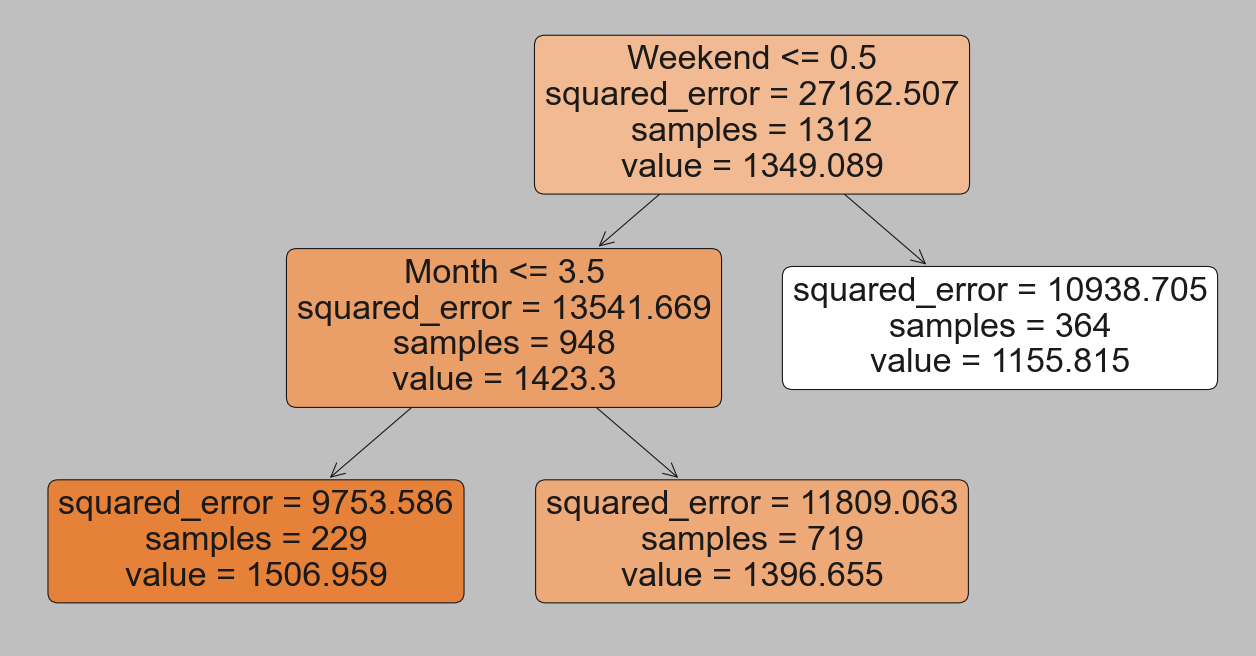

In [34]:
# Datensatz aufteilen in Trainings-, Validierungs- und Testmenge mit Hilfsfunktion generate_sets
'''
1) min_samples_split = minimale sample in Node um weiter zu spliten
2) export_text(dtr, feature_names = feature_names):
|--- Weekday <= 4.50
|   |--- Month <= 3.50
|   |   |--- value: [1505.91]
|   |--- Month >  3.50
|   |   |--- value: [1399.61]
|--- Weekday >  4.50
|   |--- value: [1152.62]
3) with plt.style.context('classic'):
            plt.figure(figsize=(20,10))
            tree.plot_tree(dtr, filled=True, impurity=True, rounded=True, feature_names=feature_names)
PLOT als bild/figure
'''
trained_decision_tree = train_decision_tree(X_train, y_train, min_samples_split = 900, min_samples_leaf = 1, output=True)

- Es folgt eine weitere Hilfsfunktion zur Vorhersage des Energieverbrauchs mithilfe des zuvor trainierten Entscheidungsbaums
- Auch an dieser Funktion müssen Sie nichts ändern und wir sprechen sie gemeinsam durch.
- Wichtig: mit dieser Funktion kann man testen, wie gut die Vorhersage auf der Validierungsmenge funktioniert, siehe Aufgabe 8

In [35]:
# Hilfsfunktion 3
def predict_with_decision_tree(dtr, X_val, y_val, output=True):
    '''
    Hilfsfunktion zur Erstellung einer Vorhersage auf Basis eines trainierten Entscheidungsbaumes und zur Ausgabe der Gütemaße.
    
    Inputs: 
    dtr: ein zuvor auf einer Trainingsmenge trainierter Entscheidungsbaum, der zur Prognose verwendet werden kann  
    X_val (df): Dataframe mit den Merkmalsvektoren der Validierungsmenge
    y_val (df): Dataframe mit den Labeln der Validierungsmenge
    output (bool): ob eine print-Ausgabe erzeugt werden soll (enthält Gütemaße), standardmäßig auf True.
   
    Outputs:
    y_pred (np.array): Vorhersage des Entscheidungsbaumes für die Merkmalsvektoren der Validierungsmenge   
    metrics_dict (dict): Dictionary mit den Metriken zur Bewertung der Vorhersagegüte
    '''  
    
    # Vorhersage für Validierungsmenge mit Entscheidungsbaum generieren
    y_pred = dtr.predict(X_val)
    
    ## Metriken zur Bewertung der Vorhersagegüte berechnen
    # Absoluten Fehler berechnen: Betrag der Differenz zwischen Vorhersage und den tatsächlichen Label der Validierungsmenge
    abs_errors = abs(y_pred - y_val)

    # Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae = mean_absolute_error(y_val, y_pred)
    
    # Relativen Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae_rel = mae/np.mean(y_val)
    
    # Mean Absolut Percentage Error (MAPE) berechnen
    mape = np.mean(abs_errors/y_val)
    
    # Mean Squared Error 
    mse = mean_squared_error(y_val, y_pred) 
    
    # Root Mean Squared Error
    rmse = np.sqrt(mse) / np.mean(y_val)
    
    metrics_dict = {'mae': mae,
                    'mse': mse,
                    'mae%': mae_rel*100,
                    'mape%': mape*100,
                    'rmse%': rmse*100
                   }
    
    if output:
        print('Mittelwert der wahren Label', round(np.mean(y_val), 2))
        print('MAE', round(mae, 4))
        print('MSE', round(mse, 4))
        print('MAE%', mae_rel*100)
        print('MAPE%', mape*100)
        print('RMSE%', rmse*100)
            
    return y_pred, metrics_dict

## Aufgabe 8
- Mit dem trainierten Entscheidungsbaum (trained_decision_tree) werden im nächsten Schritt Vorhersagen für die Validierungsmenge erstellt
- Die Vorhersagen des Entscheidungsbaums werden innerhalb von Hilfsfunktion 3 mit den tatsächlichen Labeln der Validierungmenge verglichen
- Verschiedene Metriken zur Bewertung der Güte der Regression können herangezogen werden, s. Vorlesung
- Was bedeutet die einzelnen Metriken, die nach Ausführen der nächsten Zelle ausgegeben werden?
- Ist das Prognosemodell gut?


Antwort:
1) Metriken zur Bewertung:
-MAE (Mean absolute Error, Mittlerer Absoluter Fehler): 1/n * sum(abs(y_pred(i) - y_true(i))). Note: 0-100 high = good, low = bad
-MAE% = MAE / (1/n * sum(y_true(i))) aus Vorlesung und Code oben = mae_rel * 100 (%)
-MAPE (Mean Absolute Percentage Error) = 1/n * sum((abs(y_pred(i) - y_true(i))) / y_true(i)) WICHTIG: !!! Bei Einschätzung lieber vermeiden und MAE% nutzen
-MAPE% = MAPE * 100%
-RMSE (Root Mean Squared Error): sqrt( 1/n * sum( sqr(y_pred(i) - y_true(i) )) )
-RMSE% = RMSE / (1/n * sum(y_true(i))) aus Vorlesung und Code oben rmse * 100 (%)
2) Ist das Prognosemodell gut?
-Pauschal kann man nicht sagen. Aber wegen MAE = 83.8374 (range: 0-100) und MAE% = 6.2814% (wenig = gut) würde ich sagen dass dieses Prognosemodell nicht schlecht ist.

In [36]:
# Erzeuge mit dem Trainierten Entscheidungsbaum eine Vorhersage für das Validierungsset
y_pred, metrics_dict = predict_with_decision_tree(trained_decision_tree, X_val, y_val, output=True)

Mittelwert der wahren Label 1343.42
MAE 85.3575
MSE 13865.3356
MAE% 6.353724797555172
MAPE% 6.723149965415572
RMSE% 8.765001025610818


C:\Users\haypsilcn\Documents\ada\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


## Aufgabe 9
- Wir wollen ein gute Wahl für den Hyperparameter min_samples_split treffen.
- Dafür gibt es Hilfsfunktion 4. Können Sie erkennen, was in der Hilfsfunktion passiert?
- Versuchen Sie einen Kommentar zu verfassen, der die Hilfsfunktion beschreibt.

In [37]:
# Hilfsfunktion 4
def optimize_hyperparam(X_train, y_train, X_val, y_val, metric='mae%'):
    '''
     Hilfsfunktion zur Auswahl der Hyperparameter min_samples_split

    Inputs:
    X_train (df): Dataframe mit den Merkmalsvektoren der Trainingsmenge
    y_train (df): Dataframe mit den Labeln der Trainingsmenge
    X_val (df): Dataframe mit den Merkmalsvektoren der Validierungsmenge
    y_val (df): Dataframe mit den Labeln der Validierungsmenge
    metric='': Parameter metric of optimize_hyperparam, in '' soll string sein z.B 'mae%' als Default

    Outputs:
    metrics_list: Liste aus Metriken (x, {'mae', 'mse', 'mae%', 'mape%', 'rmse%'}) wobei x = zu suchen Hyperparameter, hier ist der 'min_samples_split' und in {...} sind die Metriken wenn min_samples_split = x
    best_metric: bester Wert für Metriken mit 'min_samples_split' = best_min_split
    best_min_split: bester Hyperparamter 'min_samples_split' range = 2..1/3 * number of samples
    ''' 
    
    # Anzahl der Beobachtungen bestimmen, funktioniert über Zeilenanzahl von X_train.
    number_of_samples = X_train.shape[0]
    
    # Noch leere Liste für Metriken erstellen, die später sukzessive gefüllt wird.
    metrics_list = []
    
    # Optimalen Wert für Metrik mit großer Zahl initialisieren
    best_metric = 100000
    
    ## Schleife zum Optimieren des Hyperparameters min_samples split
    # min_samples_split wird auf Werte zwischen 2 und int(np.floor(1/5*number_of_samples)) gesetzt und in Einserschritten erhöht.
    # Für jedes gesetzte min_samples_split wird ein Entscheidungsbaum trainiert 
    # und dessen Performance anhand der Validierungsmenge getestet
    for min_samples_split in range(2, int(np.floor(1/3*number_of_samples))):
        
        # Trainieren eines Entscheidungsbaums mit bestimmtem Wert für min_samples_split 
        decision_tree = train_decision_tree(X_train, y_train, min_samples_split = min_samples_split, output=False)
        
        # Auswerten der Performance des Entscheidungsbaums durch Einsetzen der Validierungsmenge 
        # und Vergleich der vorhergesagten Label y_pred mit den wahren Labeln y_val
        y_pred, metrics_dict = predict_with_decision_tree(decision_tree, X_val, y_val, output=False)
        metrics_list.append((min_samples_split, metrics_dict))
        
        # Finden des optimalen Werts für min_samples_split
        if metrics_dict[metric] <= best_metric:
            best_metric = metrics_dict[metric]
            best_min_split = min_samples_split 
            
    ## Plotten der Ergebnisse 
    # Linienplot mit (x=Werte für min_samples_split, y=Wert der ausgewählten Metrik)
    plt.figure(figsize=(20,10))
    sns.lineplot(x=[i[0] for i in metrics_list], y=[i[1][metric] for i in metrics_list])
    # Vertikale Linie bei x=best_min_split
    plt.axvline(x=best_min_split, color='k', linestyle = '--')
    # Horizontale Linie bei dazugehörigem y, sowie Legende erzeugen
    plt.axhline(y=best_metric, color='k', linestyle = '--', 
                label='Bester Wert für min_samples_split: ' + str(best_min_split) + '\n' + metric + ': ' + str(best_metric))
    plt.legend()
    
    # Ausgabe der Funktion
    return metrics_list, best_metric, best_min_split


## Aufgabe 10
- Führen Sie die obige Zelle aus, sodass die Funktion optimize_hyperparam() definiert wird.
- Wenden Sie anschließend die Funktion optimize_hyperparam() an durch ausführen der unteren Zelle und bestimmen Sie metrics_list, best_metric und best_min_split
- Wie interpretieren Sie den erzeugten Plot? Wie sollten Sie den Hyperparameter min_samples_split setzen?

Antwort:
Interpretation des Plots:
x-Achse: min_sample_split
y-Achse: mae%
Wenn wir nach besten min_samples_split suchen möchten, müssen wir den Punkt mit den niedrigsten Wert für y-Achse entspricht mae% suchen und dann können wir den zugehörigen Wert aus x-Achse für min_sample_split einsetzen.

C:\Users\haypsilcn\Documents\ada\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\haypsilcn\Documents\ada\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\haypsilcn\Documents\ada\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\haypsilcn\Documents\ada\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\haypsilcn\Documents\ada\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\haypsilcn\Documents\ada\venv\lib\site-packages\sklearn\b

best_metric =  5.414276115037632
best_min_split =  53


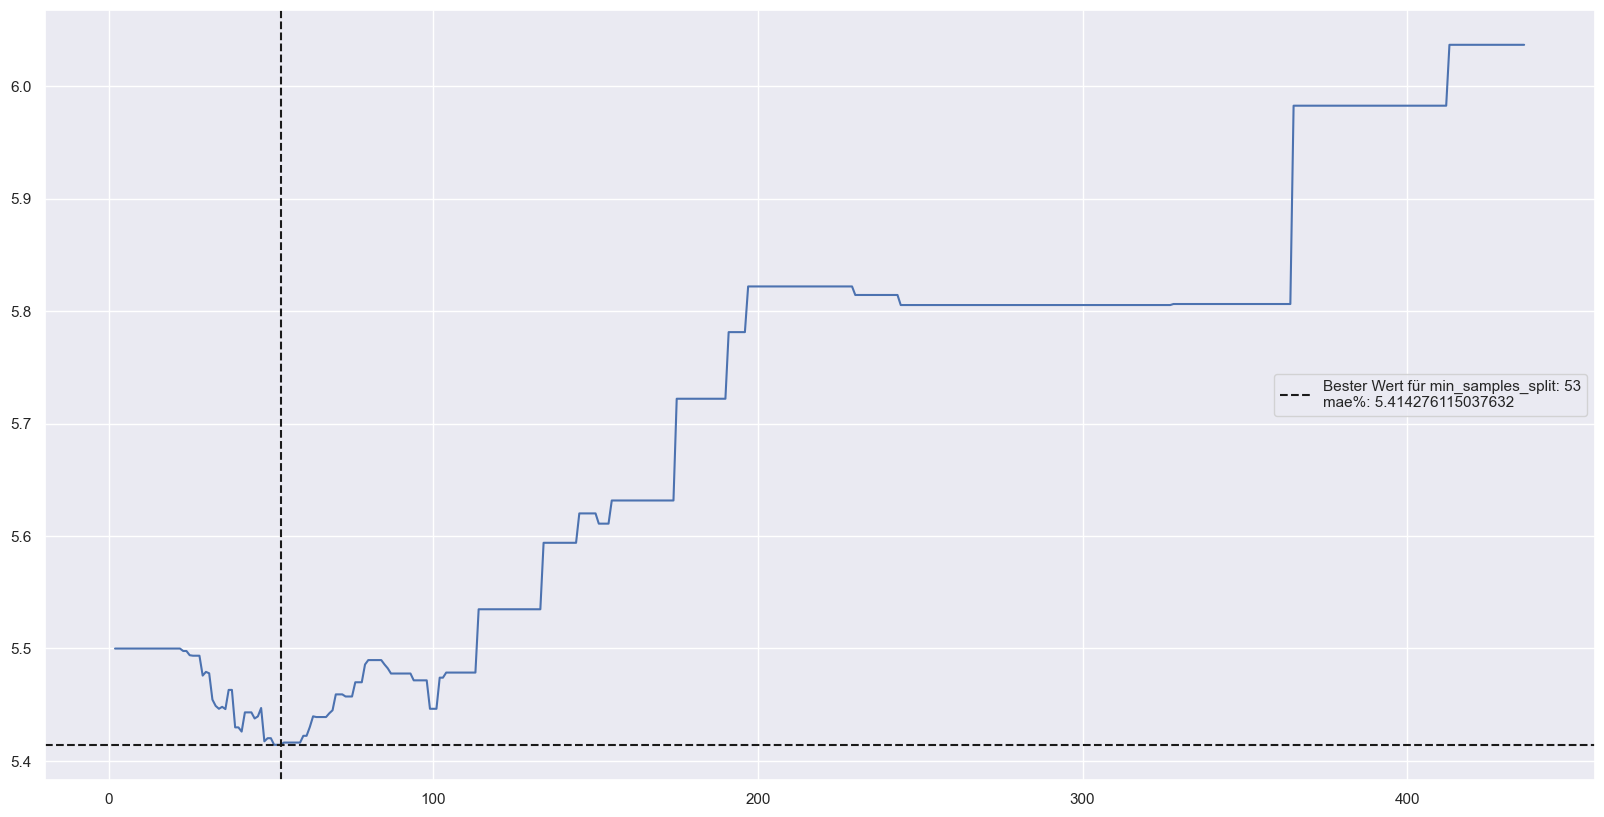

In [39]:
metrics_list, best_metric, best_min_split = optimize_hyperparam(X_train, y_train, X_val, y_val)
# in die Klammer muss noch etwas rein, was?


## Aufgabe 11
- Trainieren Sie erneut einen Entscheidungsbaum und setzten Sie dabei gezielt min_samples_split auf den gefundenen optimalen Wert, indem Sie die unten stehende Funktion ausführen.
- Was sagen Sie zu dem Ergebnis?
- Wenn Sie mit einem Fehler %mae <= 7% zufrieden wären, welche Werte für best_min_split könnten Sie setzen? Welchen Wert würden Sie wählen, um eine gute Interpretierbarkeit des Baumes durch den Menschen zu gewährleisten?

Antwort:
1) Was sagen Sie zu dem Ergebnis? Ich würde sagen, dass es sehr wahrscheinlich overfitting wär
2) Wenn wir mit einem Fehler %mae <= 7% zufrieden wären.
-Dann können wir laut Hilfsfunktion und Plot, alle Werte aus 2..1/3 * (anzahl der Datensätze) für best_min_split setzen.
-Um eine gute Interpretierbarkeit des Baumes durch den Menschen zu gewährleisten, würde ich 400 wählen.

|--- Weekend <= 0.50
|   |--- Month <= 3.50
|   |   |--- Month <= 2.50
|   |   |   |--- Month <= 1.50
|   |   |   |   |--- Weekday <= 3.50
|   |   |   |   |   |--- Weekday <= 1.50
|   |   |   |   |   |   |--- value: [1508.63]
|   |   |   |   |   |--- Weekday >  1.50
|   |   |   |   |   |   |--- value: [1543.73]
|   |   |   |   |--- Weekday >  3.50
|   |   |   |   |   |--- value: [1491.03]
|   |   |   |--- Month >  1.50
|   |   |   |   |--- Weekday <= 1.50
|   |   |   |   |   |--- value: [1533.34]
|   |   |   |   |--- Weekday >  1.50
|   |   |   |   |   |--- value: [1549.74]
|   |   |--- Month >  2.50
|   |   |   |--- Weekday <= 3.50
|   |   |   |   |--- Weekday <= 0.50
|   |   |   |   |   |--- value: [1456.18]
|   |   |   |   |--- Weekday >  0.50
|   |   |   |   |   |--- value: [1470.67]
|   |   |   |--- Weekday >  3.50
|   |   |   |   |--- value: [1436.09]
|   |--- Month >  3.50
|   |   |--- Month <= 9.50
|   |   |   |--- Month <= 4.50
|   |   |   |   |--- Weekday <= 0.50
|   |   |   

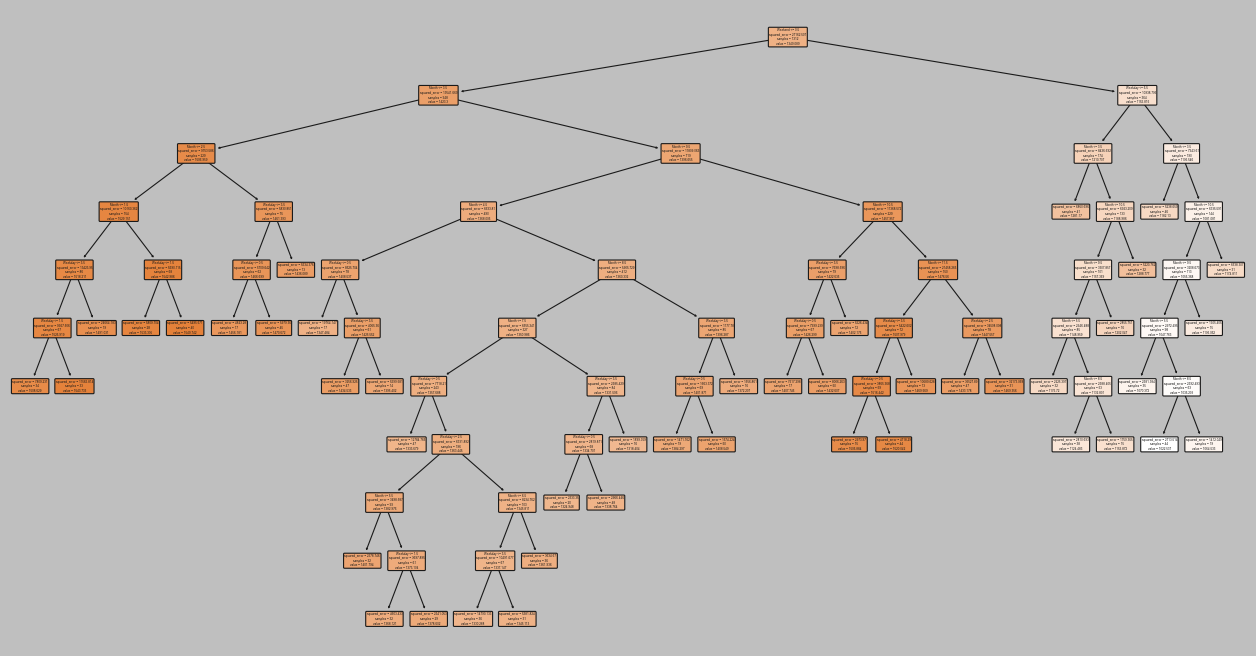

In [40]:
# Trainiere Entescheidungsbaum mit min_samples_split = best_min_split
# best_min_split ist dabei der beste gefundene Wert für diesen Hyperparameter aus der Optimierungs oben.
decision_tree_large = train_decision_tree(X_train, y_train, min_samples_split = best_min_split, output=True)



|--- Weekend <= 0.50
|   |--- Month <= 3.50
|   |   |--- value: [1506.96]
|   |--- Month >  3.50
|   |   |--- Month <= 9.50
|   |   |   |--- Month <= 4.50
|   |   |   |   |--- value: [1408.54]
|   |   |   |--- Month >  4.50
|   |   |   |   |--- Month <= 8.50
|   |   |   |   |   |--- value: [1350.99]
|   |   |   |   |--- Month >  8.50
|   |   |   |   |   |--- value: [1396.29]
|   |   |--- Month >  9.50
|   |   |   |--- value: [1457.96]
|--- Weekend >  0.50
|   |--- value: [1155.82]

Folgende Merkmale waren verfügbar: ['Weekday', 'Month', 'Weekend']
Mittelwert der wahren Label 1343.42
MAE 80.3729
MSE 12919.1073
MAE% 5.982686216661108
MAPE% 6.404908291273337
RMSE% 8.460636382506927


C:\Users\haypsilcn\Documents\ada\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


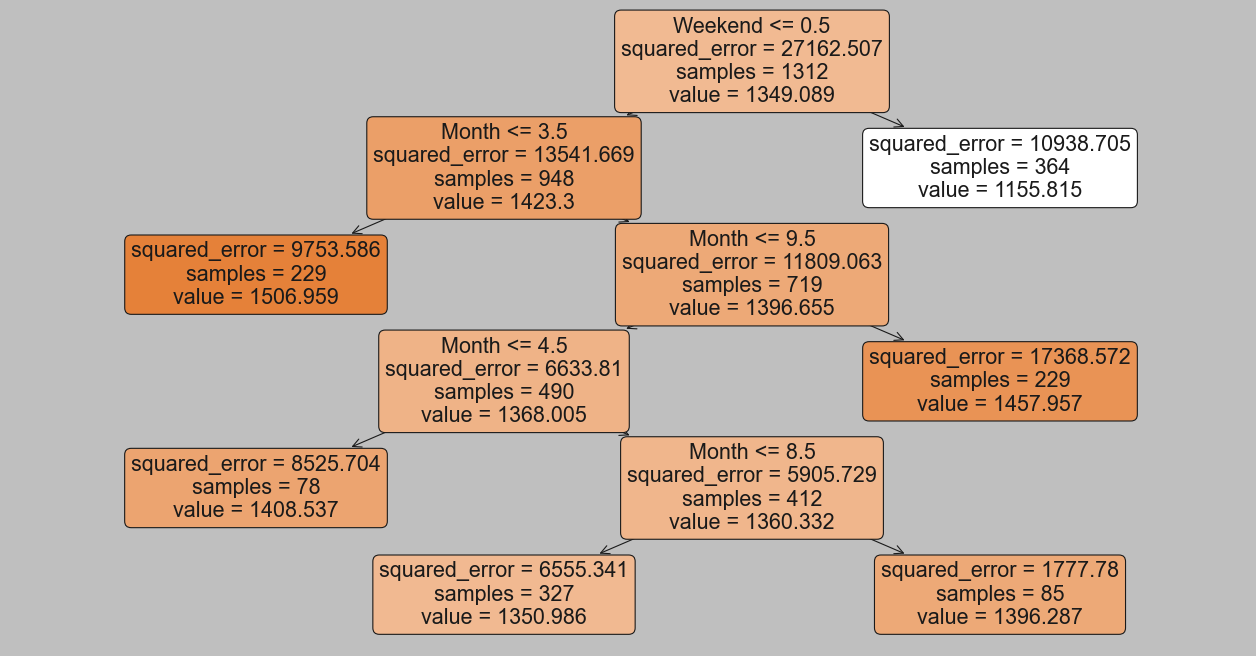

In [42]:
# Trainiere einen kleineren Entscheidungsbaum durch setzen eines anderen Wertes für min_samples_split, sodass mae% vertretbar
anderen_wert = 400
# Diese Zeile wieder einkommentieren und anpassen
decision_tree_smaller = train_decision_tree(X_train, y_train, min_samples_split = anderen_wert, output=True)


# Überprüfe Performance auf Validierungsmenge
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_val, y_val, output=True)

## Aufgabe 12
- Prüfen Sie die Performance des großen und des kleinen Entscheidungsbaumes auf dem Testset.
- Wie interpretieren Sie die Ergebnisse? Wäre der kleine Entscheidungsbaum vertretbar?


Antwort: ...

In [43]:
# Performance des großen Entscheidungsbaums auf dem Testset
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_large, X_test, y_test, output=True)

# Ausgabe einer leeren Zeile für die Übersichtlichkeit
print()

# Performance des kleinen Entscheidungsbaums auf dem Testset
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_test, y_test, output=True)


Mittelwert der wahren Label 1346.9
MAE 70.4286
MSE 9310.3646
MAE% 5.228941211983527
MAPE% 5.435084755690978
RMSE% 7.163870852091378

Mittelwert der wahren Label 1346.9
MAE 80.9344
MSE 11835.9378
MAE% 6.00893361442541
MAPE% 6.25846369869065
RMSE% 8.077291194536043


C:\Users\haypsilcn\Documents\ada\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\haypsilcn\Documents\ada\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
